
# ROBOT WARS

## Text Classification of Legitimate & Computer Generated Amazon Reviews
*Can machines fight machines?*
---

![amazon](https://productimages.nimbledeals.com/nimblebuy/amazoncom-egift-card-34-47169-regular.jpg)

### Background
---


In the United States, more than 80% of consumers indicate they use online reviews before [purchasing a product](https://www.pewresearch.org/internet/wp-content/uploads/sites/9/2016/12/PI_2016.12.19_Online-Shopping_FINAL.pdf). As reviews are among the most influential factors on consumers' buying behavior, fraudulent actors are tempted to hire writers who specialize in or use automated methods for generating fake reviews to enhance the attractiveness of their products and services. Technological progress in text generation – natural language processing (NLP) and machine learning (ML) to be more specific – has incentivized the automation of fake reviews, as with generative language models, fake reviews could be generated at scale and a fraction of the cost compared to human-generated fake reviews.


Studies have shown that:
>* 76% of U.S. consumers trust online reviews as much as [recommendations from family and friends](https://www.brightlocal.com/research/local-consumer-review-survey)
>* An extra star on a restaurant's Yelp rating can [increase revenue by 5% to 9%](https://www.hbs.edu/ris/Publication%20Files/12-016_a7e4a5a2-03f9-490d-b093-8f951238dba2.pdf)


With ecommerce being forecast to grow by 50 percent over the next four years, reaching about [7.4 trillion dollars by 2025](https://www.statista.com/statistics/379046/worldwide-retail-e-commerce-sales), this may incentivize bad actors to perpetuate this fradulent act and the problem of fake reviews may prove to be persistent.

### Problem Statement
---
Given a dataset of ~40K Amazon Reviews (50% are legitimate & 50% are computer generated using GPT-2). The dataset can be downloaded [here](https://osf.io/tyue9/). In this project, we will compare the performance of both Machine Learning and Deep Learning Models.

**Problem Type**: NLP Binary Classification
<br>
**Evaluation Metric**: Model performance will be evaluated using F1-score (>0.9).


In this notebook, we will preprocess the text in the dataset and perform Exploratory Data Analysis to better understand the data.

In [1]:
# contraction library is required, uncomment to install
# !pip install contractions

In [2]:
# Standard libraries go here
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


# For Bag-of-Words processing
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
import contractions
import re

### Loading Dataset and Preliminaries


The dataset consists of 4 columns, with 40432 rows.


* `category`: Product category of item/s under review
* `rating`: Rating of the review
* `label`: CG - Computer Generated, OR - Original
* `text_`: Text content of review


We will not be using the `rating` column for review.

In [3]:
reviews = pd.read_csv('fake reviews dataset.csv')
reviews.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
reviews.shape

(40432, 4)

In [5]:
reviews.dtypes

category     object
rating      float64
label        object
text_        object
dtype: object

There are no missing values in this dataset.

In [6]:
reviews.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

### Standardizing Column Names

We shall remove the redundant underscore to standardize the text column. No changes to the other columns are required.

In [7]:
reviews.rename(columns={'text_':'text'}, inplace=True)

### Standardizing Category Labels


The category labels have an extra '_5' at the end of the string, we shall standardize the contents of the `category` column into snake case and remove the redundant characters at the back

In [8]:
reviews['category'] = reviews['category'].apply(lambda x: x.lower().replace('_5',''))

### Numerical Labelling of Class


**Fake reviews will be labelled as Class '1'**, while real reviews will be labelled as Class '0'.

In [9]:
reviews['class'] = reviews['label'].apply(lambda x: 1 if x == 'CG' else 0)
reviews.head()

,category,rating,label,text,class
0,home_and_kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1
1,home_and_kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1
2,home_and_kitchen,5.0,CG,This pillow saved my back. I love the look and...,1
3,home_and_kitchen,1.0,CG,"Missing information on how to use it, but it i...",1
4,home_and_kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1


### Text Cleaning


We will preprocess the text to remove the unecessary noise. In the function below the following text cleaning actions were taken.

* Expanded the contractions (eg. isn't is replaced by is not, shan't is replaced by shall not etc.) using the contractions library
* Converted all text to lowercase
* Removed html tags
* Removed web addresses 
* Removed numbers


The clean text is then saved to a `.csv`file for downstream use.

In [10]:
 def preprocess(sentence):
    '''

    Takes input of a document, converts to lowercase and removes special symbols, numbers and web addresses. 
    Tokenizes words and DOES NOT remove stop words

    '''
    sentence=str(sentence)
    expand = contractions.fix(sentence, slang=True)
    lowercase = expand.lower()
    cleanr = re.compile('<.*?>&nbsp;')
    cleantext = re.sub(cleanr, '', lowercase)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    
    return ' '.join(tokens)

In [11]:
reviews_clean = reviews.copy()
reviews_clean['clean_text'] = reviews_clean['text'].apply(lambda x: preprocess(x))

## Exploratory Data Analysis (EDA)

#### Removal of Duplicate and Missing Values

In [12]:
display(reviews_clean.head())
print(reviews_clean.shape)

,category,rating,label,text,class,clean_text
0,home_and_kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,love this well made sturdy and very comfortabl...
1,home_and_kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,love it a great upgrade from the original i ha...
2,home_and_kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,this pillow saved my back i love the look and ...
3,home_and_kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,missing information on how to use it but it is...
4,home_and_kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,very nice set good quality we have had the set...


(40432, 6)


In [13]:
print(reviews_clean.isnull().sum())
print(reviews_clean['clean_text'].duplicated().sum())

category      0
rating        0
label         0
text          0
class         0
clean_text    0
dtype: int64
41


In [14]:
reviews_clean[reviews_clean['clean_text'].duplicated()]

,category,rating,label,text,class,clean_text
725,home_and_kitchen,4.0,CG,Easy to put together and looks nice and the fi...,1,easy to put together and looks nice and the fi...
4010,home_and_kitchen,1.0,CG,"<div id=""video-block-R35RA3JRQQJM8N"" class=""a-...",1,input type hidden name value
4735,sports_and_outdoors,3.0,CG,It does the job but it takes a lot of practice...,1,it does the job but it takes a lot of practice...
6025,sports_and_outdoors,5.0,CG,"This is a really good starter kit, with lots o...",1,this is a really good starter kit with lots of...
6708,sports_and_outdoors,5.0,CG,"Great, no complaints. Comfortable, phone fits ...",1,great no complaints comfortable phone fits in ...
7575,sports_and_outdoors,5.0,CG,"<div id=""video-block-RFSBG1YPR3MRI"" class=""a-s...",1,this is a great knife for the money and a grea...
11956,electronics,5.0,CG,"<div id=""video-block-R1TWZK14HQADKC"" class=""a-...",1,input type hidden name value ssl images amazon
11958,electronics,4.0,CG,"<div id=""video-block-RWOK1Y3WFP2O7"" class=""a-s...",1,input type hidden name value
12548,movies_and_tv,5.0,CG,One of the best movies of the year. Not for e...,1,one of the best movies of the year not for eve...
12769,movies_and_tv,4.0,CG,It was a good movie. I liked the movie. The pl...,1,it was a good movie i liked the movie the plot...


In [15]:
reviews_clean.drop_duplicates(subset=['clean_text'], inplace=True)
print(reviews_clean.shape)

(40391, 6)


#### Text Analysis

In [16]:
# Distribution of number of words in a review
reviews_clean['text_word_length'] = reviews_clean['text'].apply(lambda x: len(x.split()))

In [17]:
# create dataframes for positive and negative classes
fake_reviews = reviews_clean[reviews_clean['class']==1]
real_reviews = reviews_clean[reviews_clean['class']==0]

We can observe that the distributions of word length is right skewed and is observed in both classes. There is also an obvious peak of 17-18 words for the computer-generated reviews.

count    40391.000000
mean        67.502265
std         69.604194
min          1.000000
25%         21.000000
50%         39.000000
75%         85.000000
max        373.000000
Name: text_word_length, dtype: float64


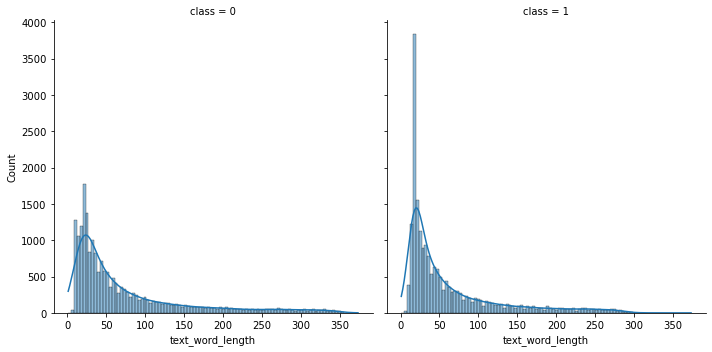

In [18]:
sns.displot(x='text_word_length', data= reviews_clean, kde=True, height=5, aspect=1, col='class', palette='Set2')
print(reviews_clean['text_word_length'].describe())

From the summary statistics above, we observe that 75% of the data consists of reviews with 85 words or less. Due to memory limitations of the local machine, we will only limit the analysis to reviews that are **100 words or less** as it still captures the bulk of the data.

In [19]:
df_100 = reviews_clean[reviews_clean['text_word_length'] < 100]

df_100_fake = df_100[df_100['class']==1]
df_100_real = df_100[df_100['class']==0]

There are many common unigrams between the real and fake reviews, in fact the top 4 unigrams are identical for both classes. 

Similarly, there are also common bigrams

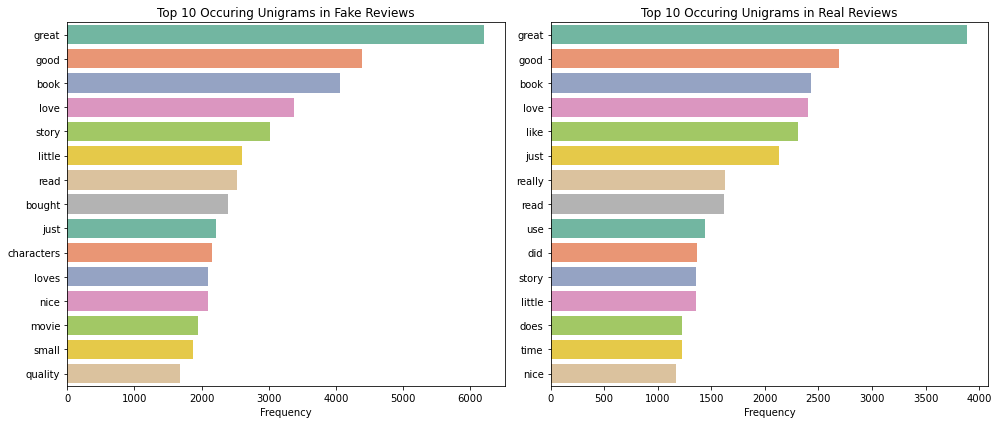

In [20]:
# Top 10 occuring words
cvec = CountVectorizer(stop_words='english')

fake_counts = cvec.fit_transform(df_100_fake['clean_text'].values)
fake_df = pd.DataFrame(fake_counts.todense(), 
                          columns=cvec.get_feature_names()).sum().sort_values(ascending=False).head(15)

real_counts = cvec.fit_transform(df_100_real['clean_text'].values)
real_df = pd.DataFrame(real_counts.todense(), 
                          columns=cvec.get_feature_names()).sum().sort_values(ascending=False).head(15)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.barplot(fake_df.values,fake_df.index, ax=axes[0], palette = 'Set2', orient='h')
sns.barplot(real_df.values,real_df.index, ax=axes[1], palette = 'Set2', orient='h')

axes[0].set_title('Top 10 Occuring Unigrams in Fake Reviews')
axes[0].set_xlabel('Frequency')
axes[1].set_title('Top 10 Occuring Unigrams in Real Reviews')
axes[1].set_xlabel('Frequency')
plt.tight_layout()

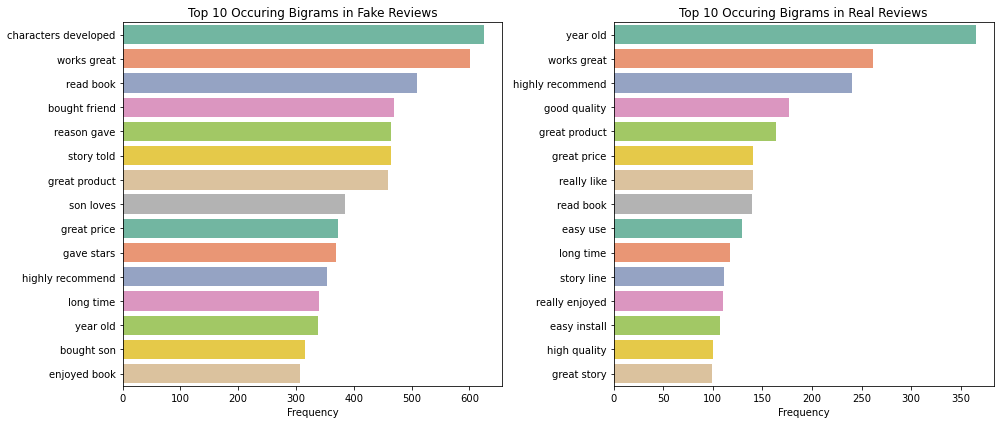

In [21]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2))

fake_counts = cvec.fit_transform(df_100_fake['clean_text'].values)
fake_df = pd.DataFrame(fake_counts.todense(), 
                          columns=cvec.get_feature_names()).sum().sort_values(ascending=False).head(15)

real_counts = cvec.fit_transform(df_100_real['clean_text'].values)
real_df = pd.DataFrame(real_counts.todense(), 
                          columns=cvec.get_feature_names()).sum().sort_values(ascending=False).head(15)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.barplot(fake_df.values,fake_df.index, ax=axes[0], palette = 'Set2', orient='h')
sns.barplot(real_df.values,real_df.index, ax=axes[1], palette = 'Set2', orient='h')

axes[0].set_title('Top 10 Occuring Bigrams in Fake Reviews')
axes[0].set_xlabel('Frequency')
axes[1].set_title('Top 10 Occuring Bigrams in Real Reviews')
axes[1].set_xlabel('Frequency')
plt.tight_layout()

### Class Distributions

Even after dropping rows to get rid of duplicated values, the dataset is still fairly balanced across category and rating.

In [22]:
# Class distribution

reviews_clean['class'].value_counts(normalize=True)

0    0.500483
1    0.499517
Name: class, dtype: float64

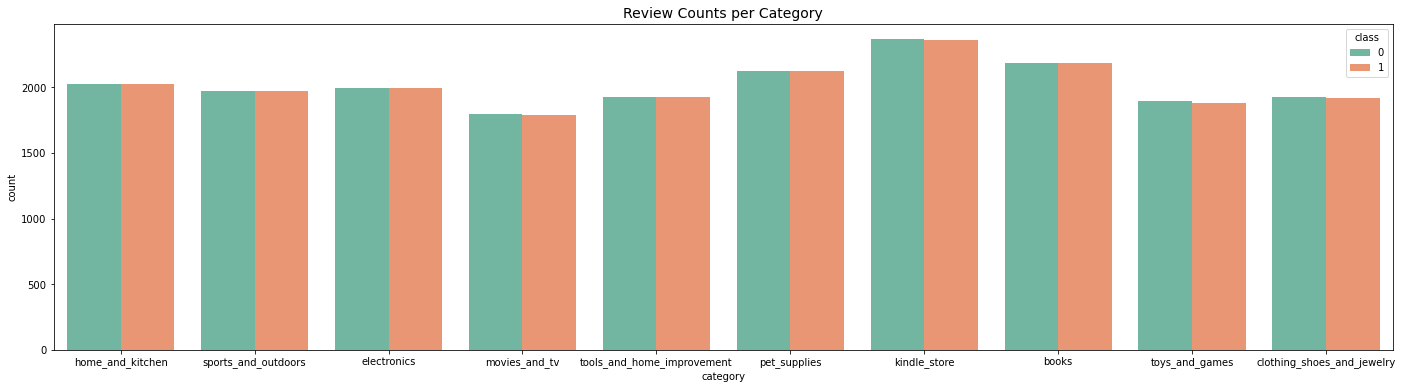

In [23]:
# Class distributions for category
plt.figure(figsize=(24,6))
sns.countplot(x='category', data=reviews_clean, hue='class', palette='Set2')
plt.title('Review Counts per Category', fontsize=14)
plt.show()

<AxesSubplot:xlabel='rating', ylabel='count'>

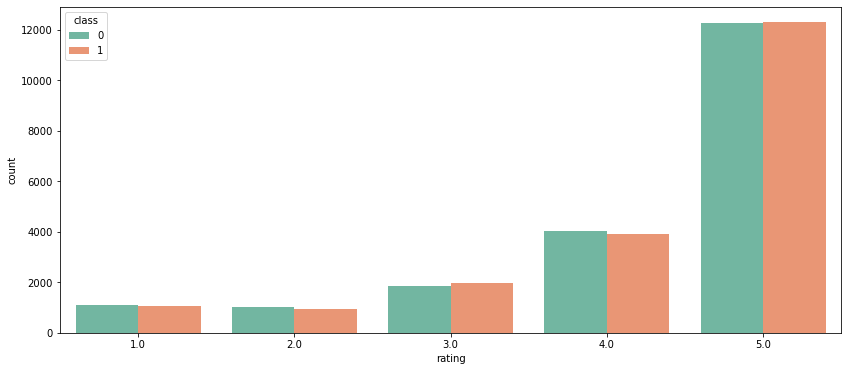

In [24]:
# Class distributions for rating
plt.figure(figsize=(14,6))
sns.countplot(x='rating', data=reviews_clean, hue='class', palette='Set2')

In [27]:
# saving the preprocessed data for use in the next notebook
reviews_clean.to_csv('../data/reviews_clean.csv', index=False)

# Notebook Conclusion


In this notebook, we have preprocessed the data, cleaned it and performed Exploratory Data Analysis. The cleaned data has also been saved as a csv file to be used in the later notebooks.


In the next notebook, we will load the clean data and feed them into the Machine Learning models.

<TBC>